# Mean bias correction

In [134]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [135]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '00:10:00'
cores = 8
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52+gdata/fs38'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])
                     # python=os.environ["DASK_PYTHON"])

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37233 instead
  warnings.warn(


In [136]:
cluster.scale(jobs=1)
client = Client(cluster)

In [137]:
client#.restart()

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/37233/status,
Dashboard: /proxy/37233/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.1:32917,Workers: 0
Dashboard: /proxy/37233/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
import xarray as xr
import numpy as np

from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib.pyplot as plt

In [6]:
path_model = "/g/data/w42/dr6273/work/data/CMIP6/ACCESS-ESM1-5/historical/day/"
path_era = "/g/data/w42/dr6273/work/data/era5/regridded/CMIP6/"

In [7]:
def open_model(var):
    """
    Open ACCESS zarr collection
    """
    return xr.open_zarr(
        path_model + var + "/" + var + "_day_ACCESS-ESM1-5_historical_1950-2014_NEM.zarr",
        consolidated=True
    )

In [8]:
def open_era(var):
    """
    Open ERA5 data regridded to ACCESS grid
    """
    return xr.open_mfdataset(
        path_era + var + "_era5_ACCESS-ESM1-5_1959-2014_NEM.nc"
    )

### Variables

Temperature (2m)

In [24]:
tas_model = open_model("tas").sel(time=slice("1959", "2014"))["tas"]

In [25]:
tas_era = open_era("2t").rename({"t2m": "tas"})["tas"]

Surface radiation

In [26]:
rsds_model = open_model("rsds").sel(time=slice("1959", "2014"))["rsds"]

In [27]:
rsds_era = open_era("rsds").rename({"msdwswrf": "rsds"})["rsds"]

sfcWind

In [28]:
sfcWind_model = open_model("sfcWind").sel(time=slice("1959", "2014"))["sfcWind"]

In [29]:
sfcWind_era = open_era("sfcWind").rename({"w10": "sfcWind"})["sfcWind"]

Precip

In [31]:
pr_model = open_model("pr").sel(time=slice("1959", "2014"))["pr"]

In [41]:
pr_era = open_era("mtpr").rename({"mtpr": "pr"})["pr"] # * 86400 # Multiple by 86400 to convert from kg m**-2 s**-1 to mm day**-1

### For a single grid cell

In [44]:
def sel_cell(ds, lat_lon):
    """
    Select grid box
    """
    return ds.sel(lat=lat_lon[0], lon=lat_lon[1], method="nearest")

In [46]:
def compute_ecdf_model(cell_da, dim1_name="time", dim2_name="member"):
    """
    Compute ECDF for each ensemble member
    """
    nT = len(cell_da[dim1_name])
    nM = len(cell_da[dim2_name])
    
    ecdf_model_x = np.empty((nT + 1, nM))
    ecdf_model_y = np.empty((nT + 1, nM))
    for i in range(nM):
        ecdf_member = ECDF(cell_da.isel({dim2_name: i}))
        ecdf_model_x[:,i] = ecdf_member.x
        ecdf_model_y[:,i] = ecdf_member.y

    ecdf_model_x = xr.DataArray(
        ecdf_model_x,
        dims=["index", "member"],
        coords={"index": range(nT + 1), "member": range(1, nM + 1)}
    )
    ecdf_model_y = xr.DataArray(
        ecdf_model_y,
        dims=["index", "member"],
        coords={"index": range(nT + 1), "member": range(1, nM + 1)}
    )
    ds = ecdf_model_x.to_dataset(name="x")
    ds["y"] = ecdf_model_y
    return ds

In [96]:
cell = (-34, 151) # lat, lon

In [97]:
def plot_ecdfs(ax, ecdf_era, ecdf_model, var_name):
    """
    Plot ECDF of ERA5 and 5th-95th percentile ranges of model ECDF.
    """
    ax.fill_betweenx(
        ecdf_model["y"].sel(member=1),
        ecdf_model["x"].quantile(0.95, "member"),
        ecdf_model["x"].quantile(0.05, "member"),
        label="Model"
    )
    ax.axvline(cell_model.mean(["time", "member"]), ls="--")

    ax.plot(ecdf_era.x, ecdf_era.y, c="darkorange", label="ERA5")
    ax.axvline(cell_era.mean("time"), c="darkorange", ls="--")

    ax.set_xlabel(var_name)
    ax.set_ylabel("ECDF")
    
    return ax

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


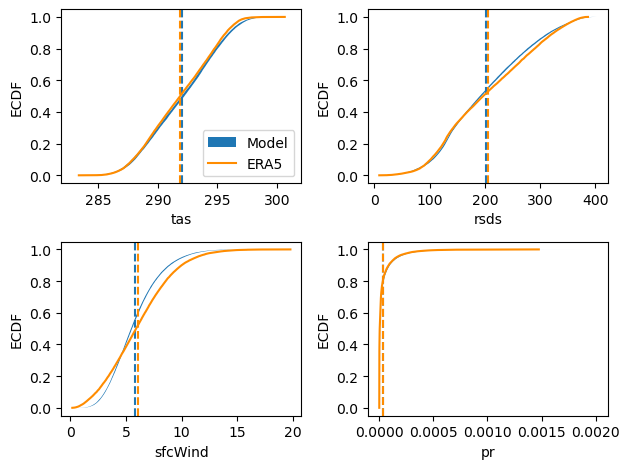

In [98]:
fig, ax = plt.subplots(2, 2)

for i, (da_era, da_model, var) in enumerate(zip(
    [tas_era, rsds_era, sfcWind_era, pr_era],
    [tas_model, rsds_model, sfcWind_model, pr_model],
    ["tas", "rsds", "sfcWind", "pr"]
)):
    # Select single cell
    cell_era = sel_cell(da_era, cell).compute()
    cell_model = sel_cell(da_model, cell).compute()
    
    # ECDFs
    ecdf_era = ECDF(cell_era)
    ecdf_model = compute_ecdf_model(cell_model)
    
    p = plot_ecdfs(ax.flatten()[i], ecdf_era, ecdf_model, var)
    
    if i == 0:
        p.legend(loc="lower right")
    
    plt.tight_layout()

### Remove bias

In [100]:
def get_clim(ds, period, dim="time"):
    """
    Return the climatology over a period of time
    """
    return ds.groupby(f'{dim}.{period}').mean(dim)

In [118]:
def get_bias(sim, obs, period, pool_members, method="additive", dim="time"):
    """
    Return the forecast bias over a period
    """
    if pool_members:
        sim_clim = get_clim(sim, period, dim).mean("member")
    else:
        sim_clim = get_clim(sim, period, dim)
        
    obs_clim = get_clim(obs, period, dim)
        
    if method == "additive":
        bias = sim_clim - obs_clim
    elif method == "multiplicative":
        bias = sim_clim / obs_clim
    else: 
        raise ValueError("Unrecognised method")
    return bias

In [126]:
def remove_bias(sim, bias, period, method="additive", dim="time"):
    """
    Remove the bias
    """
    if method == "additive":
        return (sim.groupby(f'{dim}.{period}') - bias).drop(period)
    elif method == "multiplicative":
        return (sim.groupby(f'{dim}.{period}') / bias).drop(period)
    else: 
        raise ValueError("Unrecognised method")

In [109]:
def plot_clim(ax, clim_era, clim_model, var_name):
    """
    Plot climatology of ERA5 and 5-95th model clim.
    """
    ax.fill_between(m_clim.dayofyear, m_clim.quantile(0.05, "member"), m_clim.quantile(0.95, "member"), label="Model")
    ax.plot(e_clim, c="darkorange", label="ERA5")

    ax.set_xlabel("day of year")
    ax.set_ylabel(var_name)
    
    return ax

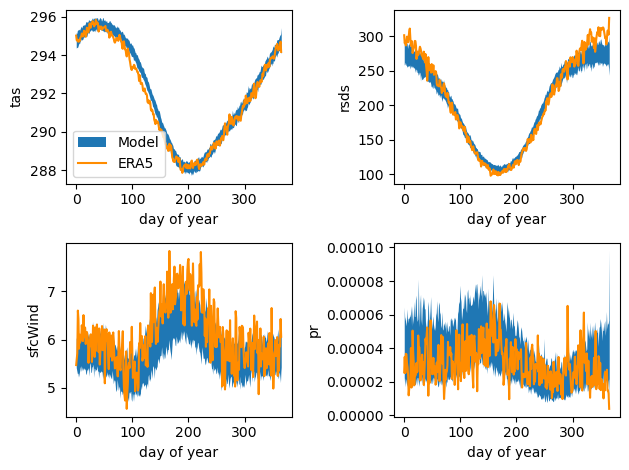

In [111]:
fig, ax = plt.subplots(2, 2)

for i, (da_era, da_model, var) in enumerate(zip(
    [tas_era, rsds_era, sfcWind_era, pr_era],
    [tas_model, rsds_model, sfcWind_model, pr_model],
    ["tas", "rsds", "sfcWind", "pr"]
)):
    # Select single cell
    cell_era = sel_cell(da_era, cell).compute()
    cell_model = sel_cell(da_model, cell).compute()
    
    # Climatology
    e_clim = get_clim(cell_era, "dayofyear")
    m_clim = get_clim(cell_model, "dayofyear")
    
    p = plot_clim(ax.flatten()[i], e_clim, m_clim, var)
    
    if i == 0:
        p.legend(loc="lower left")
    
    plt.tight_layout()

KeyboardInterrupt: 

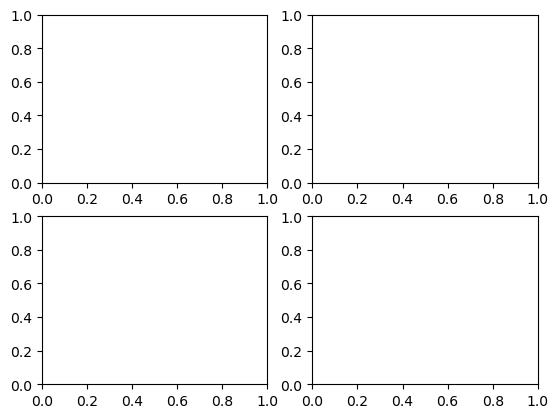

In [152]:
fig, ax = plt.subplots(2, 2)

for i, (da_era, da_model, var) in enumerate(zip(
    [tas_era, rsds_era, sfcWind_era, pr_era],
    [tas_model, rsds_model, sfcWind_model, pr_model],
    ["tas", "rsds", "sfcWind", "pr"]
)):
    # Select single cell
    cell_era = sel_cell(da_era, cell).compute()
    cell_model = sel_cell(da_model, cell).compute()
    
    # Remove bias
    if var == "tas":
        method = "additive"
    else:
        method == "multiplicative"
    m_bc = remove_bias(
        cell_model,
        get_bias(cell_model, cell_era, "dayofyear", True, method),
        "dayofyear",
        method
    )
    
    # climatology
    m_bc_clim = get_clim(m_bc, "dayofyear")
    e_clim = get_clim(cell_era, "dayofyear")
    
    p = plot_clim(ax.flatten()[i], e_clim, m_bc_clim, var)
    
    if i == 0:
        p.legend(loc="lower left")
    
    plt.tight_layout()

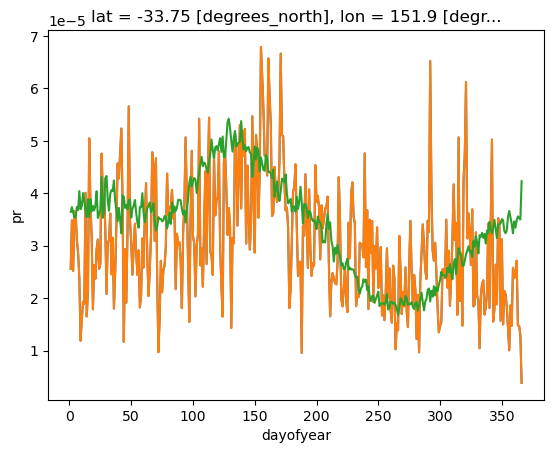

In [151]:
m_bc = remove_bias(
        cell_model,
        get_bias(cell_model, cell_era, "dayofyear", True, "multiplicative"),
        "dayofyear",
        "multiplicative"
    )
get_clim(m_bc, "dayofyear").mean("member").plot()
e_clim.plot()
get_clim(cell_model, "dayofyear").mean("member").plot()

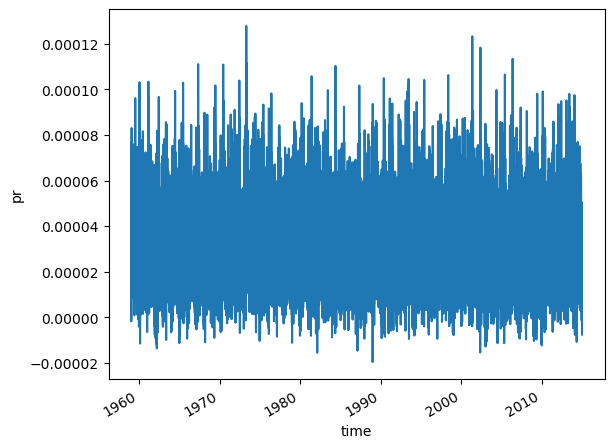

In [141]:
m_bc.mean("member").plot()

In [140]:
cell_model

<xarray.DataArray 'pr' (member: 40, time: 20454)>
array([[4.0362206e-08, 1.2395049e-06, 7.8024959e-06, ..., 3.5204481e-05,
        1.3095051e-05, 2.7440930e-05],
       [4.5729348e-07, 2.4032712e-04, 9.2233247e-05, ..., 4.7757339e-07,
        2.0788228e-05, 9.0150957e-07],
       [1.1503092e-05, 4.0583532e-06, 1.9879173e-04, ..., 7.9105957e-09,
        2.2638173e-05, 3.2153843e-05],
       ...,
       [4.1000058e-05, 2.1398702e-04, 6.5864551e-05, ..., 4.9526636e-07,
        2.6547264e-07, 6.7247029e-08],
       [0.0000000e+00, 5.5879200e-06, 2.0515611e-06, ..., 3.0980695e-07,
        1.4637013e-04, 2.2473318e-06],
       [9.2845048e-06, 3.7305165e-06, 8.6086766e-06, ..., 4.5990755e-06,
        1.0274533e-06, 2.1762280e-06]], dtype=float32)
Coordinates:
    lat      float64 -33.75
    lon      float64 151.9
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40
  * time     (time) datetime64[ns] 1959-01-01T12:00:00 ... 2014-12-31T12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        includes both liquid and solid phases
    history:        2020-09-22T10:40:40Z altered by CMOR: replaced missing va...
    long_name:      Precipitation
    standard_name:  precipitation_flux
    units:          kg m-2 s-1